# Time Series Forecasting with Machince Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Type of Time Series Data
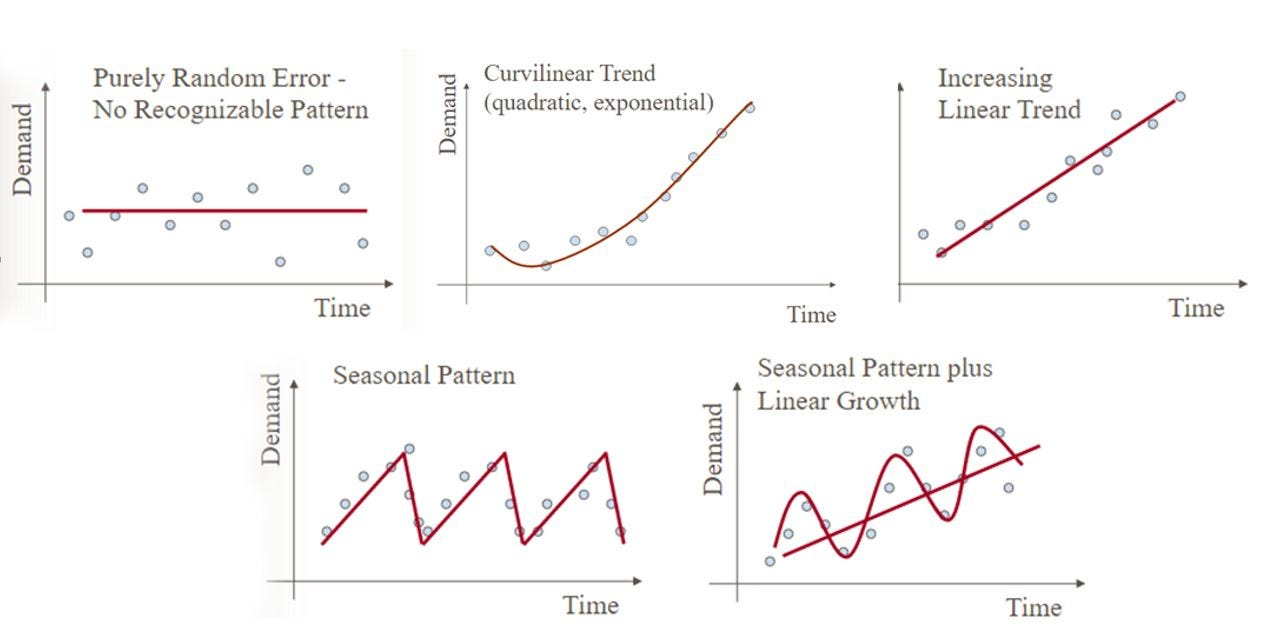

In [2]:
df = pd.read_csv(r"PJME_hourly.csv")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy Use in MW'}, xlabel='Datetime'>

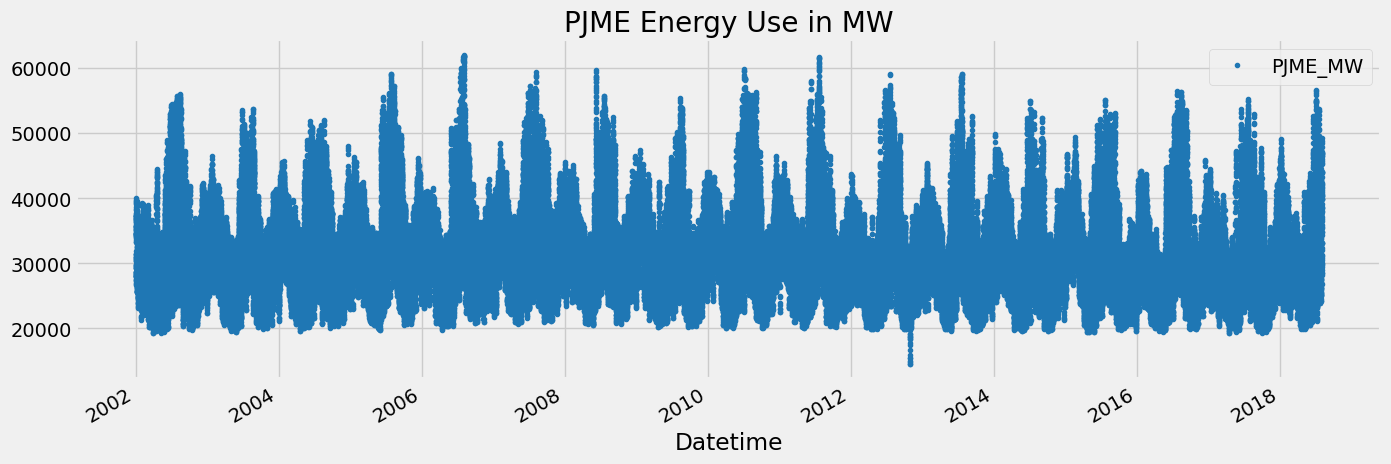

In [3]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')

# Train/Test Split

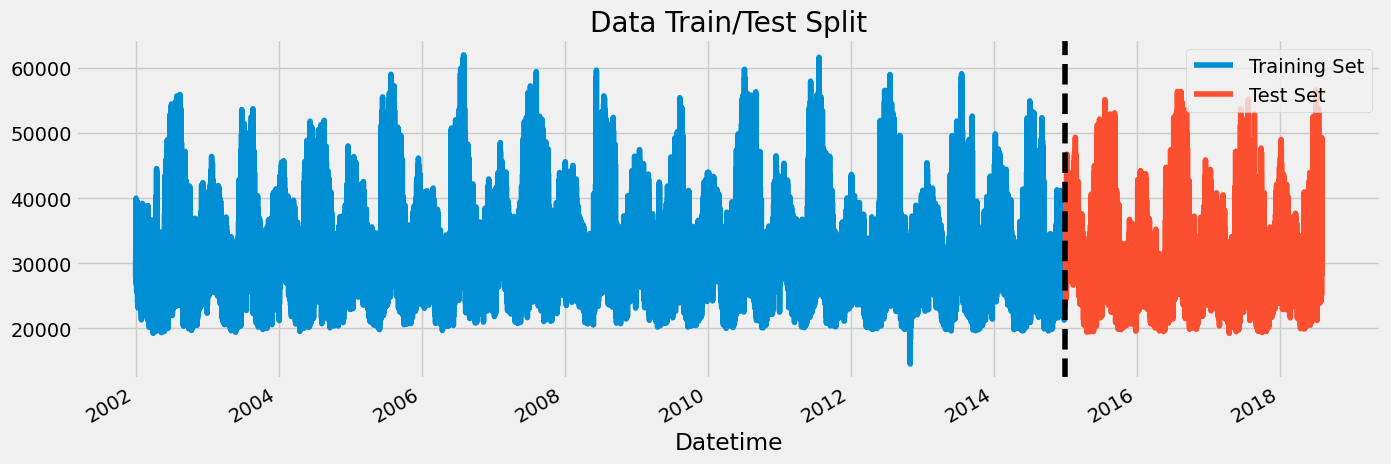

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

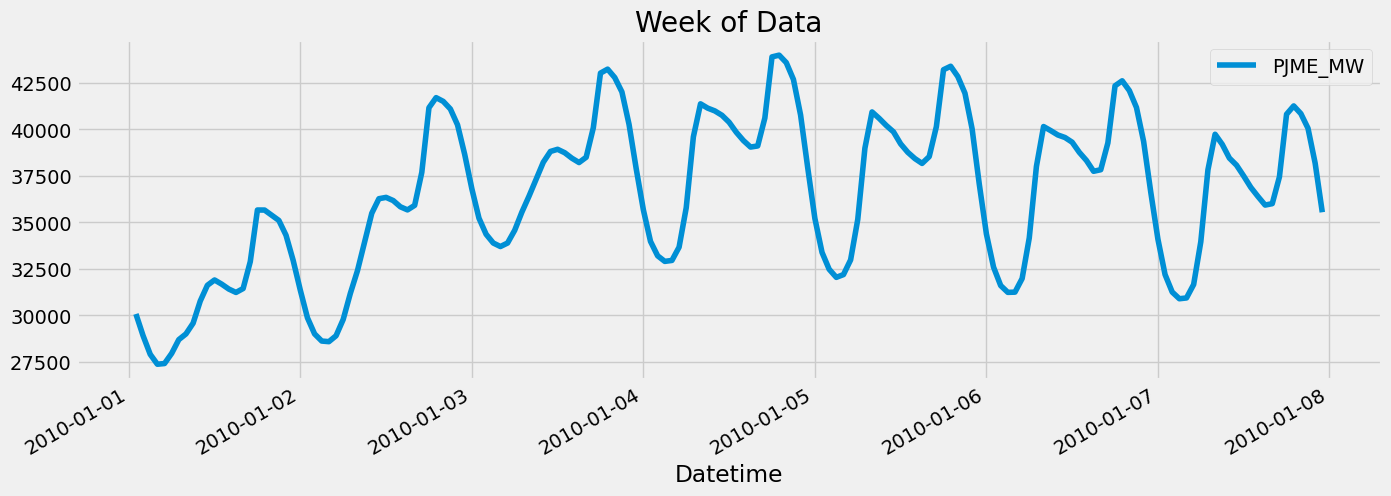

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week of Data')
plt.show()

# Feature Creation

In [6]:
def create_features(df):
    """
    Create a time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# Visualize our Feature/Target Relationship

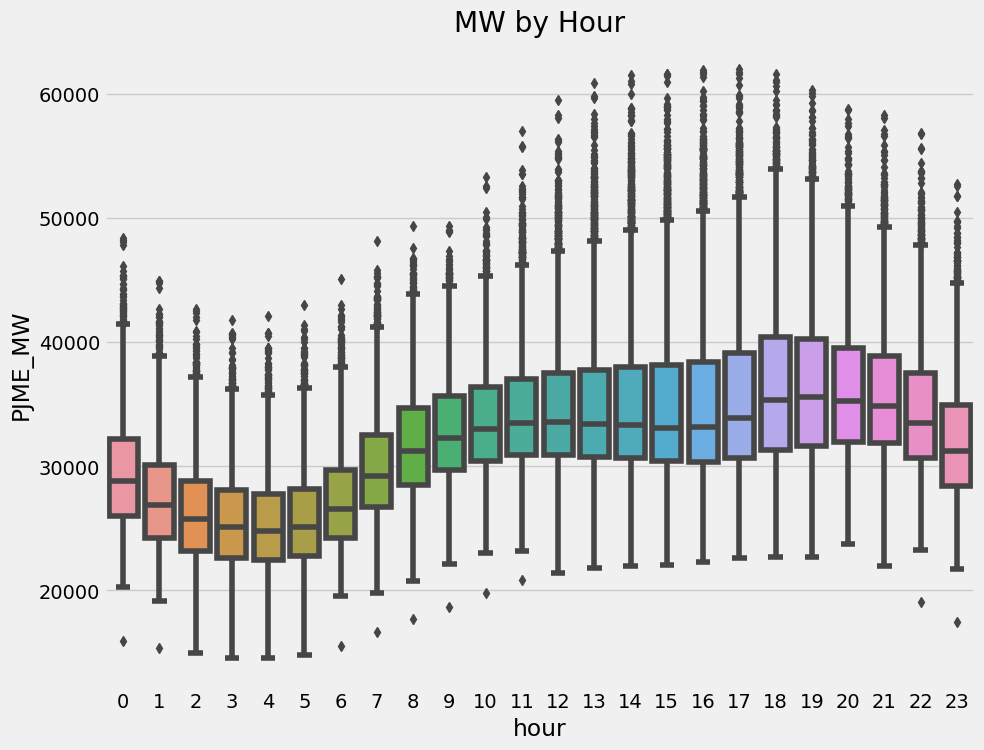

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

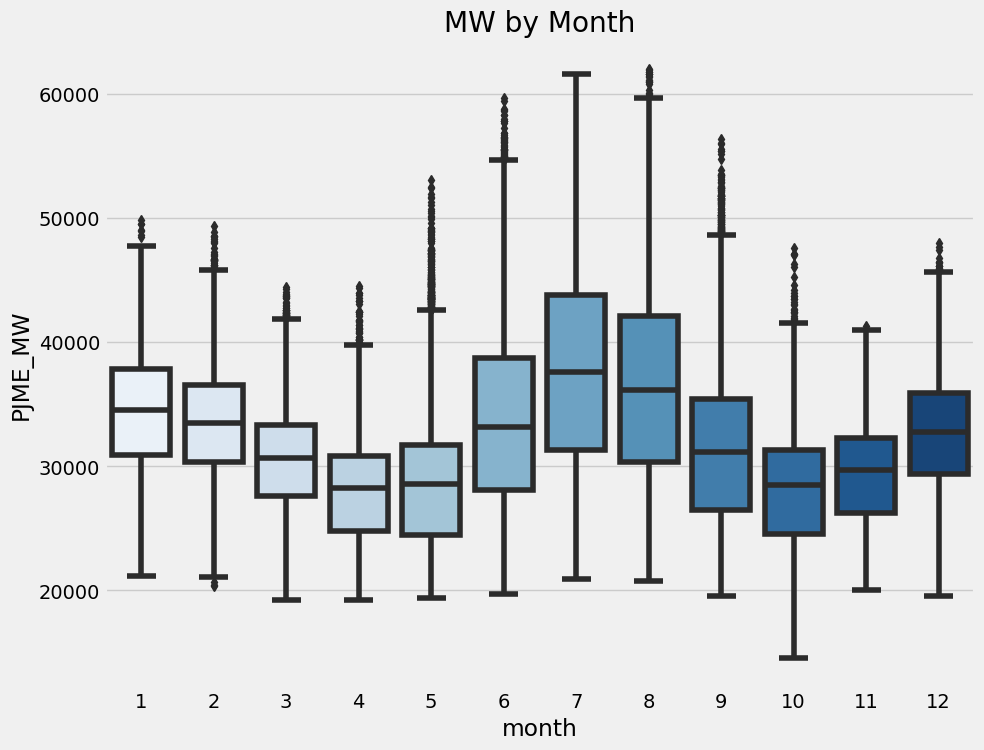

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [9]:
train = create_features(train)
test = create_features(test)
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [12]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.001)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:32894.63731	validation_1-rmse:31946.77347
[100]	validation_0-rmse:29802.40434	validation_1-rmse:28850.26822
[200]	validation_0-rmse:27007.68256	validation_1-rmse:26052.37585
[300]	validation_0-rmse:24482.32583	validation_1-rmse:23533.86101
[400]	validation_0-rmse:22201.28958	validation_1-rmse:21261.60426
[500]	validation_0-rmse:20141.56874	validation_1-rmse:19211.83146
[600]	validation_0-rmse:18281.67829	validation_1-rmse:17373.02835
[700]	validation_0-rmse:16603.55487	validation_1-rmse:15717.84372
[800]	validation_0-rmse:15090.25111	validation_1-rmse:14218.03651
[900]	validation_0-rmse:13726.70240	validation_1-rmse:12872.56965
[999]	validation_0-rmse:12510.66291	validation_1-rmse:11682.75145


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importances

In [21]:
fi = pd.DataFrame(reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

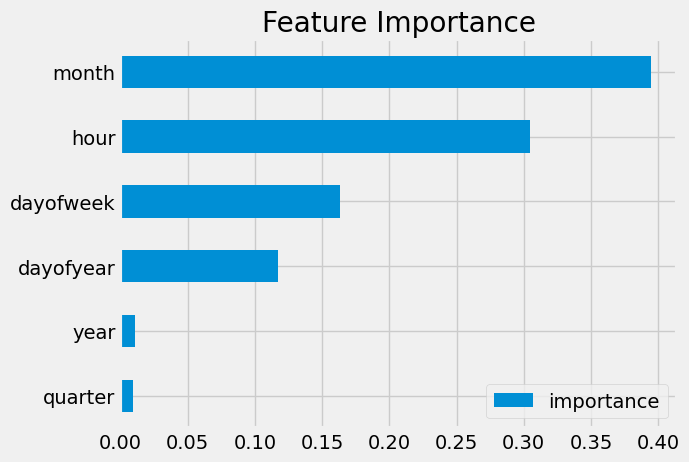

In [24]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

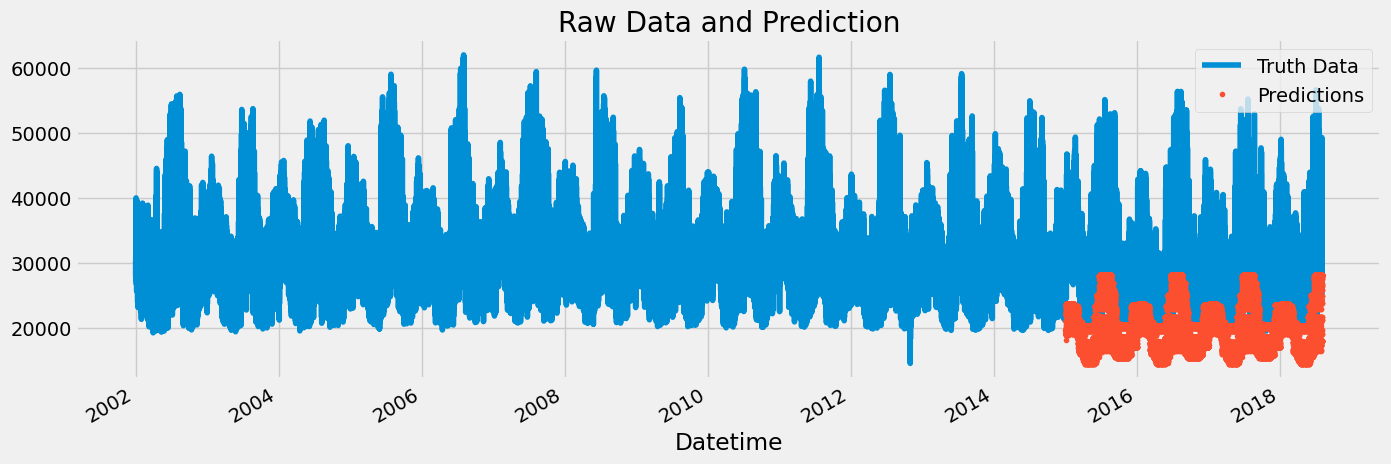

In [35]:
import warnings
warnings.filterwarnings("ignore")

test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

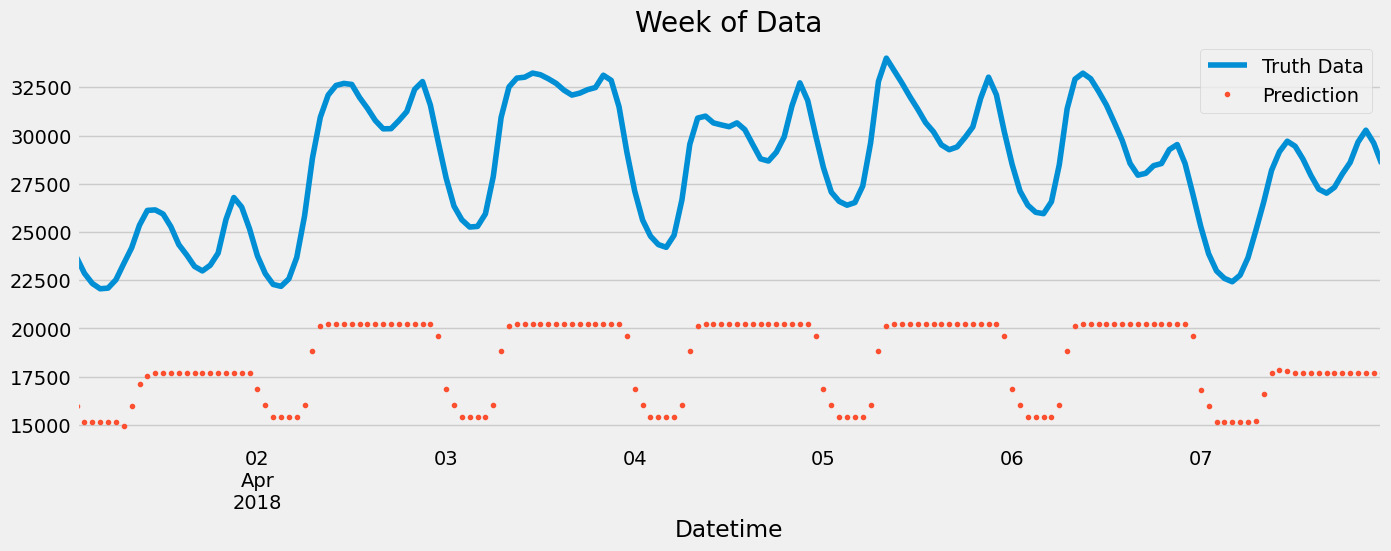

In [41]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [46]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 11682.75


# Calculate Error
 - Look at the worst and best predicted days

In [54]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    23997.148763
2016-08-14    23322.571126
2018-01-06    22894.879801
2015-02-20    22736.142415
2016-09-10    22425.864665
Name: error, dtype: float64

In [55]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2017-02-19    4041.490967
2015-12-25    4058.008870
2017-02-25    4209.918213
2016-07-04    4277.139648
2017-09-02    4291.761515
Name: error, dtype: float64

# Next Steps
 - More robust cross validation
 - Add more features (weather forecast, holidays)